# Importaciones

In [40]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.optim import Adam, lr_scheduler, SGD
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as pl
import splitfolders
import torchvision
import pandas as pd



In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Organizacion de los datos

In [42]:
carpeta_general = 'starting-package/data x200/'
#splitfolders.ratio(carpeta_general, output="dataset", seed=42, ratio=(.7, .2, .1), group_prefix=None)# para este caso hemos particionado el conjunto de datos en 70% de entrenamiento, 20% validación y 10% para prueba. según los resultados de la validación se ve afectada a la hora de entrenar porque posee mucho pocos datos
# puede ser este el motivo por la cantidad de clases por validar. Para resolver hemos decidido eliminar el conjunto de prueba y repartiremos los datos en entrenamiento y validación con 60 y 40 porciento respectivamente.
#splitfolders.ratio(carpeta_general, output="dataset2", seed=42, ratio=(.6, .4), group_prefix=None)

Copying files: 11788 files [02:04, 94.37 files/s]


comprobación de las nuevas carpetas creadas

In [ ]:
directorio = './dataset2/'
print(os.listdir(directorio))

['train', 'val']


In [ ]:
clases = os.listdir(directorio + "/train")
print(clases)

['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet', '008.Rhinoceros_Auklet', '009.Brewer_Blackbird', '010.Red_winged_Blackbird', '011.Rusty_Blackbird', '012.Yellow_headed_Blackbird', '013.Bobolink', '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting', '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird', '020.Yellow_breasted_Chat', '021.Eastern_Towhee', '022.Chuck_will_Widow', '023.Brandt_Cormorant', '024.Red_faced_Cormorant', '025.Pelagic_Cormorant', '026.Bronzed_Cowbird', '027.Shiny_Cowbird', '028.Brown_Creeper', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo', '032.Mangrove_Cuckoo', '033.Yellow_billed_Cuckoo', '034.Gray_crowned_Rosy_Finch', '035.Purple_Finch', '036.Northern_Flicker', '037.Acadian_Flycatcher', '038.Great_Crested_Flycatcher', '039.Least_Flycatcher', '040.Olive_sided_Flycatcher', '041.Scissor_tailed_Flycatcher', '042.Ver

Cargar los datos como tensores

In [ ]:
transformation = transforms.Compose([transforms.Resize((150, 150)), # todas las imagenes van a tener un tamaño de pixel de 128x128
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(), # se hizo la transformación de 0-255 el tono de color para 0-1 como tensores
                                     transforms.Normalize([0.5, 0.5, 0.5], # se hizo la normalización de '0-1' para '-1,1', con la fórmula (x-mean)/std
                                                          [0.5, 0.5, 0.5]),
                                    
                                    ])

In [ ]:
train_dataset = ImageFolder(directorio+'/train', transform=transformation)
#test_dataset = ImageFolder(directorio+'/test', transform=transformation)
validation_dataset = ImageFolder(directorio+'val', transform=transformation)

In [ ]:
img, label = train_dataset[0]
print(img.shape, label)
img

torch.Size([3, 150, 150]) 0


tensor([[[0.3647, 0.3647, 0.3569,  ..., 0.3882, 0.3804, 0.3804],
         [0.4118, 0.4039, 0.3961,  ..., 0.3490, 0.3490, 0.3490],
         [0.4431, 0.4353, 0.4196,  ..., 0.3255, 0.3412, 0.3333],
         ...,
         [0.3098, 0.3333, 0.3412,  ..., 0.2314, 0.2157, 0.2000],
         [0.3020, 0.3020, 0.3098,  ..., 0.2471, 0.2392, 0.2392],
         [0.2706, 0.2627, 0.2471,  ..., 0.2784, 0.2627, 0.2627]],

        [[0.4118, 0.4118, 0.4039,  ..., 0.4196, 0.4118, 0.4118],
         [0.4588, 0.4510, 0.4431,  ..., 0.3804, 0.3804, 0.3804],
         [0.4902, 0.4824, 0.4667,  ..., 0.3569, 0.3725, 0.3647],
         ...,
         [0.3490, 0.3725, 0.3804,  ..., 0.2706, 0.2627, 0.2471],
         [0.3490, 0.3490, 0.3569,  ..., 0.2863, 0.2863, 0.2863],
         [0.3333, 0.3255, 0.3098,  ..., 0.3176, 0.3098, 0.3098]],

        [[0.3961, 0.3961, 0.3882,  ..., 0.4118, 0.4039, 0.4039],
         [0.4431, 0.4353, 0.4275,  ..., 0.3725, 0.3725, 0.3725],
         [0.4745, 0.4667, 0.4510,  ..., 0.3490, 0.3647, 0.

En este cada imagen de las clases representa una tupla compuesta por el tensor de la imagen y la etiqueta o clase a que pertenence. 

Visualización

In [ ]:

def vis_imagen(img, label):
    print('Etiqueta:', train_dataset.classes[label], "("+str(label)+")")
    pl.imshow(img.permute(1,2,0))
    pl.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Etiqueta: 002.Laysan_Albatross (1)


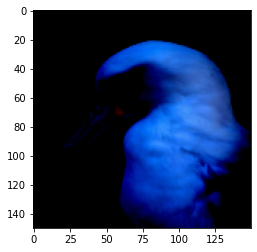

In [ ]:
imgs, labels = train_dataset[58]
vis_imagen(imgs, labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Etiqueta: 003.Sooty_Albatross (2)


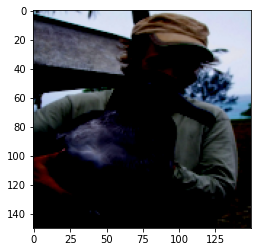

In [ ]:
vis_imagen(*train_dataset[90])

In [ ]:
batch_size=16
nrows_plot=4

Cargar los datos en la cpu con el Dataloader

In [ ]:
train_dl = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dl = DataLoader(validation_dataset, batch_size=256*2, shuffle=True)
#test_dl = DataLoader(test_dataset, batch_size=16, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


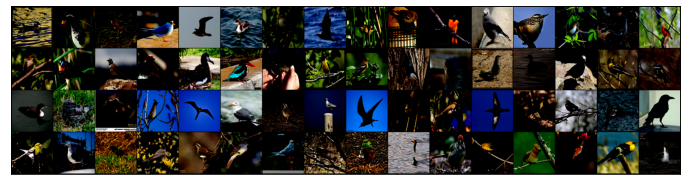

In [ ]:
def check_lote(dl):
    for image, labels in dl:
        fig, ax = pl.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(image,nrow=16).permute(1, 2, 0))
        break
check_lote(train_dl)

 Visualizacion del conjunto de entrenamiento

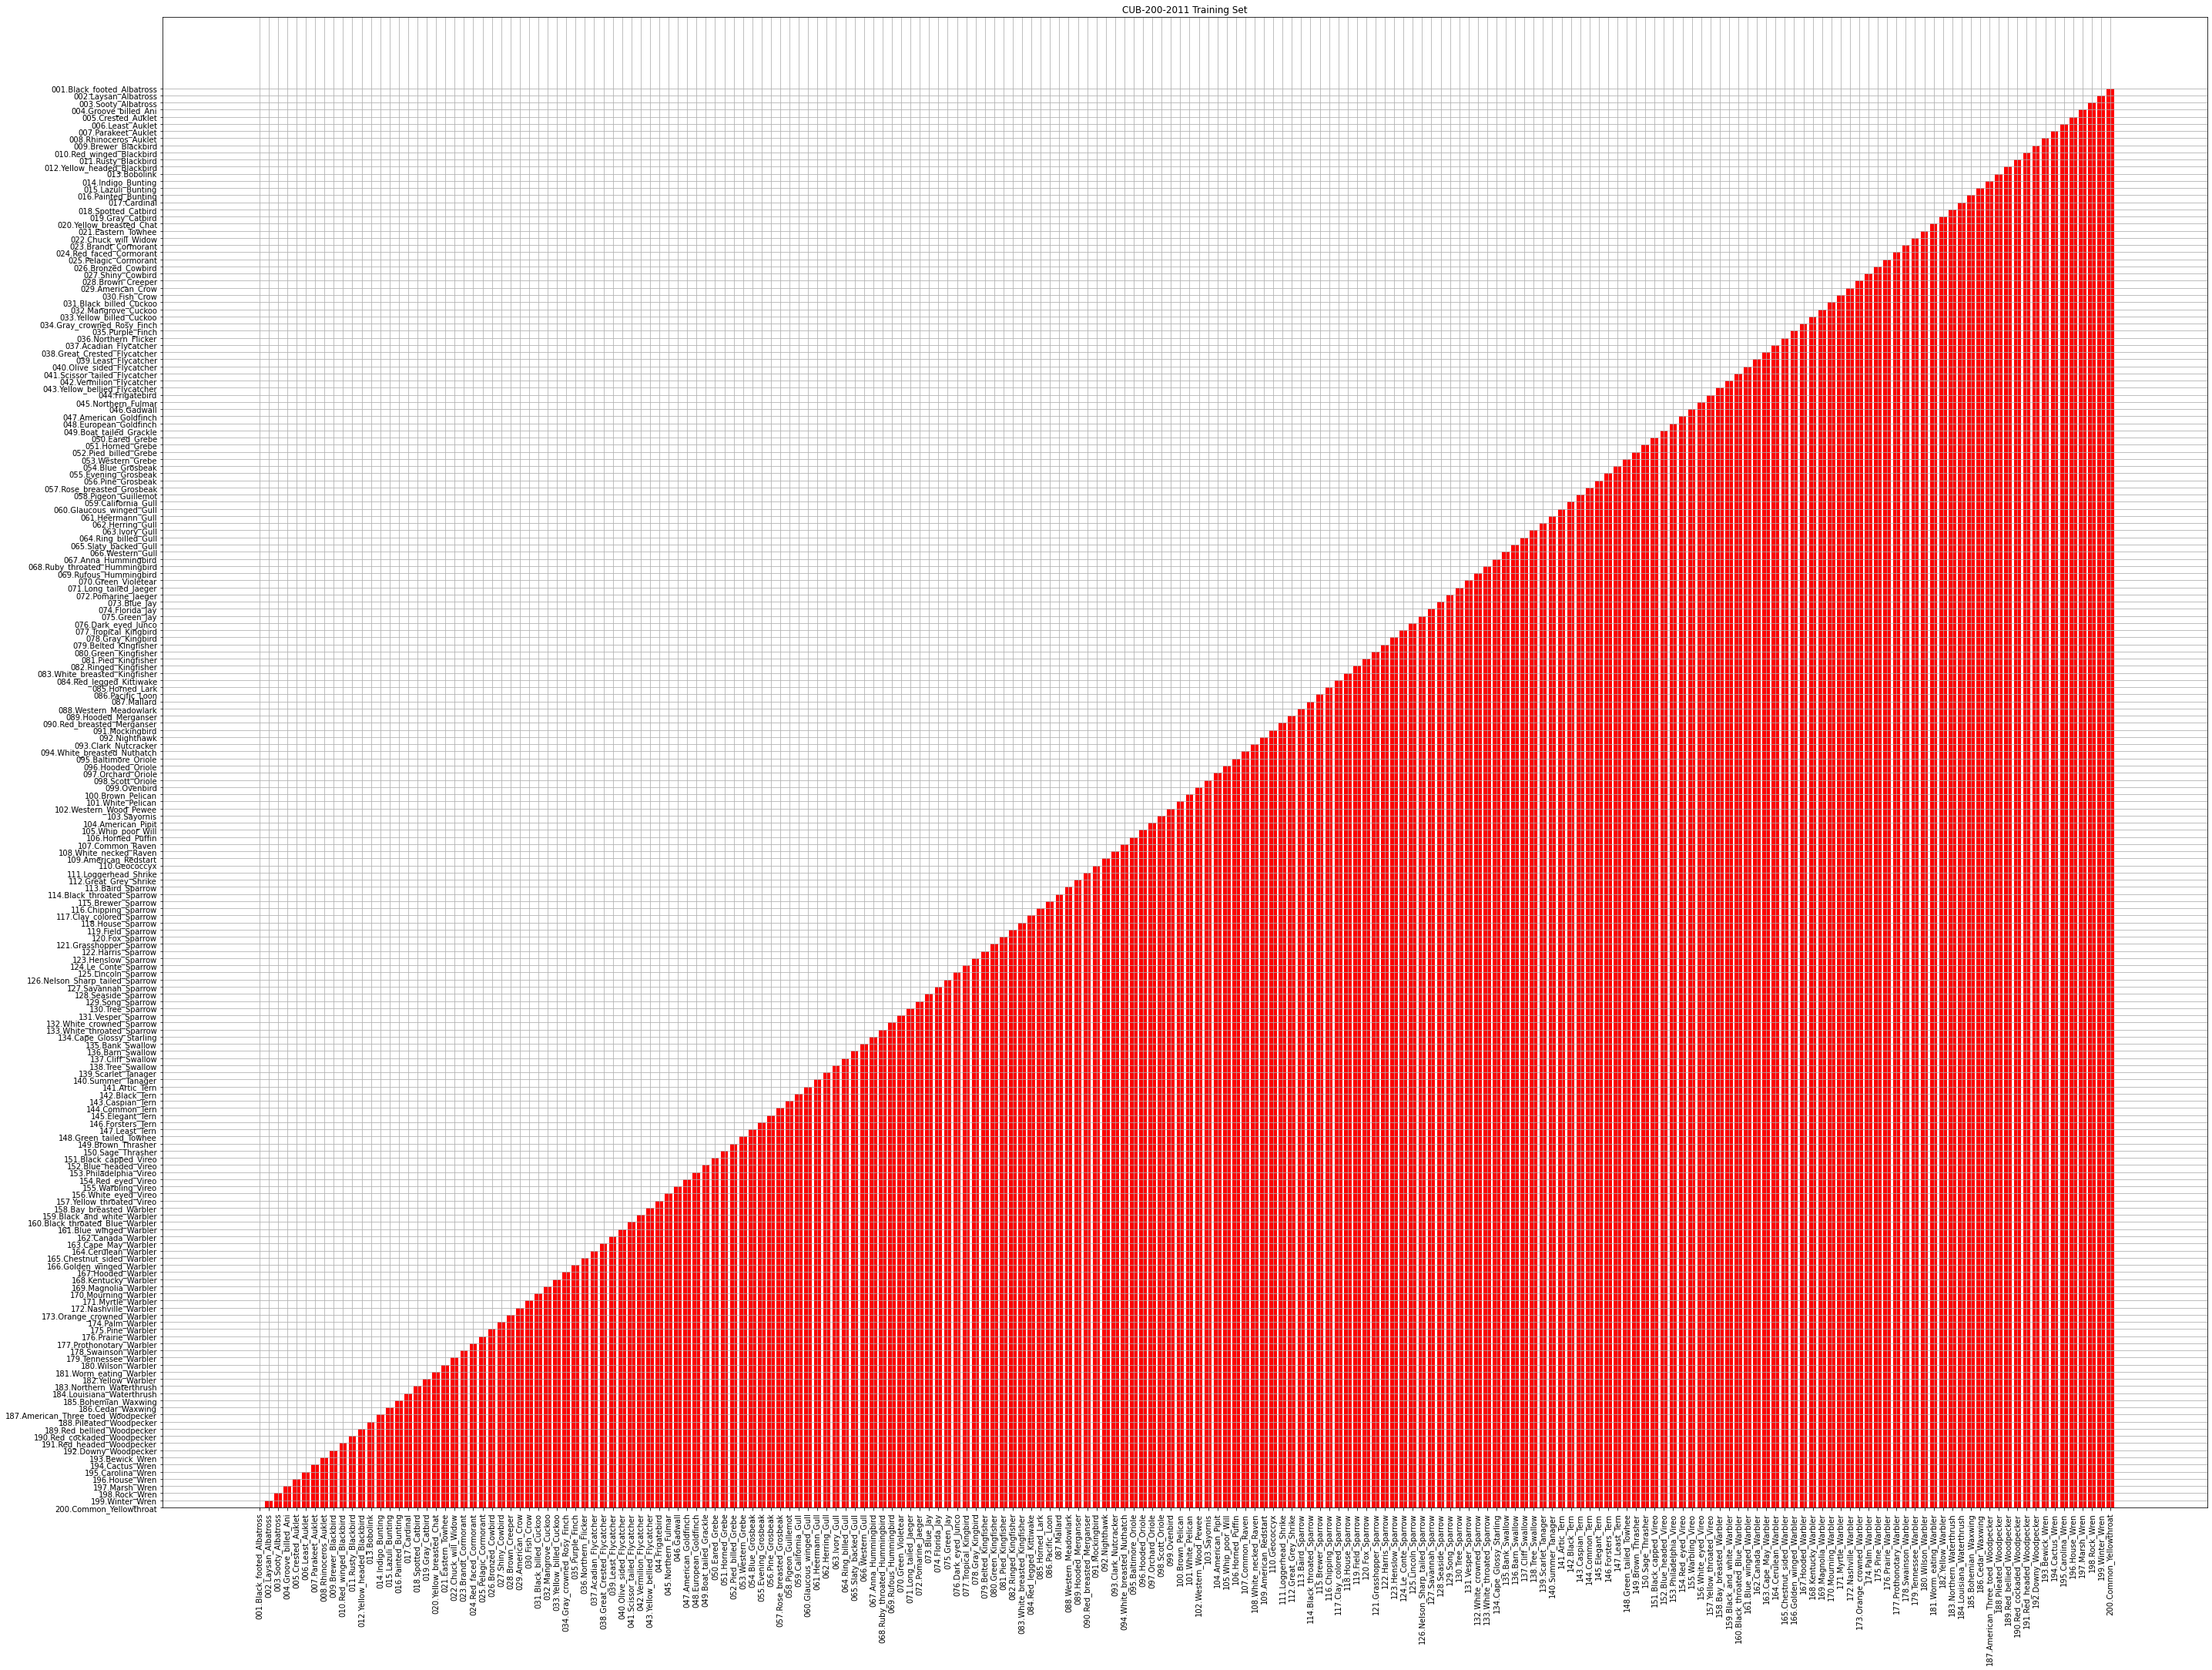

In [ ]:
pl.figure(figsize=(40,30))
pl.bar(x=train_dataset.classes, height=pd.DataFrame(train_dataset.classes[label]).sort_values(ascending=False),color='red')
pl.xticks(rotation=90)
pl.tight_layout()
pl.grid(True)
pl.title('CUB-200-2011 Training Set')
pl.show()

# Entrenamiento y Validación

CNN 1

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=200):
        super(ConvNet, self).__init__()


        # Input shape= (256, 3, 128,128)

        self.conv1=nn.Conv2d(in_channels=3, out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,128,128)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #shape= (256,12,128,128)
        self.relu1= nn.ReLU()
        #shape = (256,12,128,128)

        self.pool = nn.MaxPool2d(kernel_size=2)
        #Reduce el tamaño de la imagen en 2
        # shape = (256,12,64,64)

        self.conv2=nn.Conv2d(in_channels=12, out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,64,64)
        self.relu2= nn.ReLU()
        #shape = (256,20,64,64)

        self.conv3=nn.Conv2d(in_channels=20, out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,64,64)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #shape= (256,32,64,64)
        self.relu3= nn.ReLU()
        #shape = (256,32,64,64)

        self.fc = nn.Linear(in_features=75*75*32, out_features=num_classes)

        #feed forward function

    def forward(self, input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)

        output=self.pool(output)

        output=self.conv2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)

        # la salida será una matriz con la forma« shape (256,32,64,64)

        output=output.view(-1, 32*75*75)

        output=self.fc(output)

        return output





Cargamos el modelo a la cpu o gpu dependiendo de la máquina que tengamos

In [ ]:
model=ConvNet(num_classes=200).to(device)

In [ ]:
#Optimizadores y función de pérdida
optimizer=Adam(model.parameters(), lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [ ]:
num_epochs=10
train_dataset_size = len(train_dataset)
validation_dataset_size = len(validation_dataset)

In [ ]:
print(train_dataset_size, validation_dataset_size)

7048 4740


In [ ]:
# Entrenamiento del modelo y salvar el mejor modelo

best_accuracy = 0.0
for epoch in range(num_epochs):

    #Evaluar y entrenar con el train_dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0

    for i, (images,labels) in enumerate(train_dl):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        optimizer.zero_grad()

        outputs = model(images)
        loss=loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss+= loss.cpu().data*images.size(0)
        _, prediction=torch.max(outputs.data, 1)

        train_accuracy+=int(torch.sum(prediction==labels.data))

    train_accuracy=train_accuracy/train_dataset_size
    train_loss=train_loss/train_dataset_size

    #Evaluar con el test_dataset
    model.eval()

    test_accuracy=0.0
    for i, (images,labels) in enumerate(val_dl):
        if torch.cuda.is_available():
            images= Variable(images.cuda())
            labels= Variable(labels.cuda())

        outputs = model(images)
        _, prediction = torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))

    test_accuracy = test_accuracy/validation_dataset_size

    print('Epoch: '+str(epoch)+' Train Loss: ' +str(int(train_loss))+' Train Accuracy: ' +str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))


    #Salvar el mejor modelo
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(), 'Best_checkpoint.model')
        best_accuracy=test_accuracy



Epoch: 0 Train Loss: 32 Train Accuracy: 0.006559766763848397 Test Accuracy: 0.005165733964700818
Epoch: 1 Train Loss: 5 Train Accuracy: 0.0060738581146744415 Test Accuracy: 0.004735256134309083
Epoch: 2 Train Loss: 5 Train Accuracy: 0.009839650145772596 Test Accuracy: 0.004735256134309083
Epoch: 3 Train Loss: 5 Train Accuracy: 0.013605442176870748 Test Accuracy: 0.005165733964700818
Epoch: 4 Train Loss: 5 Train Accuracy: 0.02793974732750243 Test Accuracy: 0.004735256134309083
Epoch: 5 Train Loss: 5 Train Accuracy: 0.06827016520894072 Test Accuracy: 0.005165733964700818
Epoch: 6 Train Loss: 4 Train Accuracy: 0.1490524781341108 Test Accuracy: 0.006026689625484288
Epoch: 7 Train Loss: 3 Train Accuracy: 0.28316326530612246 Test Accuracy: 0.005165733964700818
Epoch: 8 Train Loss: 2 Train Accuracy: 0.4585762876579203 Test Accuracy: 0.0038743004735256135
Epoch: 9 Train Loss: 2 Train Accuracy: 0.6276724975704567 Test Accuracy: 0.005596211795092553


# entrenamiento con un modelo preentrenado para la mejora de los resultados

In [ ]:
model_name = 'resnet152'
model_ft = models.resnet152(pretrained=True)

c:\Users\SYDNEY_X1\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SYDNEY_X1\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


después de se haber descargado el modelo, hay necesidad de modificar la capa de salida "output_layer" del modelo, porque este modelo fue pre_entrenado para una clasificacion de imagenes de 1000 clases, y en nuestro caso solo tenemos 200 clases, 

In [ ]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

decimos a la maquina que le vamos a pasar el modelo

In [ ]:
model_ft = model_ft.to(device)

Definicion de la funcion de perdida, optimizador y taza de aprendizaje

In [ ]:
criterio = nn.CrossEntropyLoss()

optimizer_ft = SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

learning_rate = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Entrenar el modelo

In [ ]:
best_accuracy = 0.0
for epoch in range(num_epochs):

    #Evaluar y entrenar con el train_dataset
    model_ft.train()
    train_accuracy=0.0
    train_loss=0.0

    for i, (images,labels) in enumerate(train_dl):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        outputs = model_ft(images)
        loss=criterio(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        optimizer_ft.zero_grad()

        train_loss+= loss.cpu().data*images.size(0)
        _, prediction=torch.max(outputs.data, 1)

        train_accuracy+=int(torch.sum(prediction==labels.data))

    train_accuracy=train_accuracy/train_dataset_size
    train_loss=train_loss/train_dataset_size

    #Evaluar con el val_dataset
    model_ft.eval()

    test_accuracy=0.0
    for i, (images,labels) in enumerate(val_dl):
        if torch.cuda.is_available():
            images= Variable(images.cuda())
            labels= Variable(labels.cuda())

        outputs = model_ft(images)
        _, prediction = torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))

    test_accuracy = test_accuracy/validation_dataset_size

    print('Epoch: '+str(epoch)+' Train Loss: ' +str(int(train_loss))+' Train Accuracy: ' +str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))


    #Salvar el mejor modelo
    if test_accuracy>best_accuracy:
        torch.save(model_ft.state_dict(), 'Best_checkpoint.model')
        best_accuracy=test_accuracy



KeyboardInterrupt: 

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)